Importing libraries

In [9]:
import pandas as pd
import numpy as np
import io
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
uploaded_file = files.upload()

Saving online_retail_II.xlsx to online_retail_II (1).xlsx


In [11]:
retail_df = pd.read_excel(io.BytesIO(uploaded_file['online_retail_II.xlsx']))

In [12]:
retail_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Exploratory Data Analysis

In [13]:
for col in retail_df.columns:
  print(col)

Invoice
StockCode
Description
Quantity
InvoiceDate
Price
Customer ID
Country


In [14]:
retail_df.describe()

,Quantity,Price,Customer ID
count,525461.000000,525461.000000,417534.000000
mean,10.337667,4.688834,15360.645478
std,107.424110,146.126914,1680.811316
min,-9600.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,13983.000000
50%,3.000000,2.100000,15311.000000
75%,10.000000,4.210000,16799.000000
max,19152.000000,25111.090000,18287.000000


## Distribution Graph






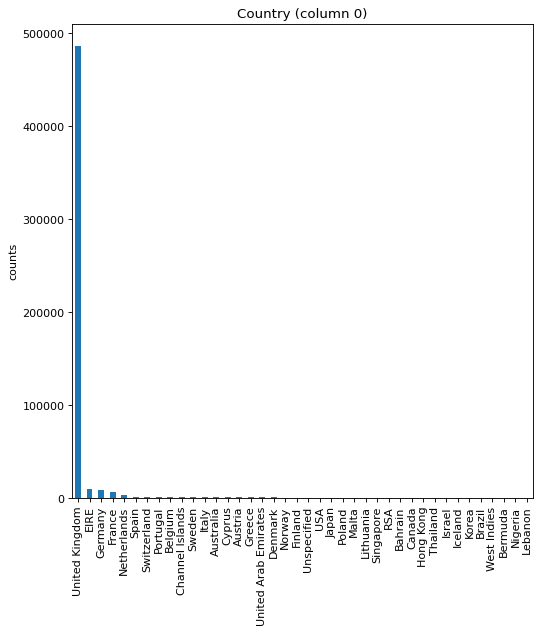

In [15]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
  
plotPerColumnDistribution(retail_df, 10 ,10)

## Correlation Matrix

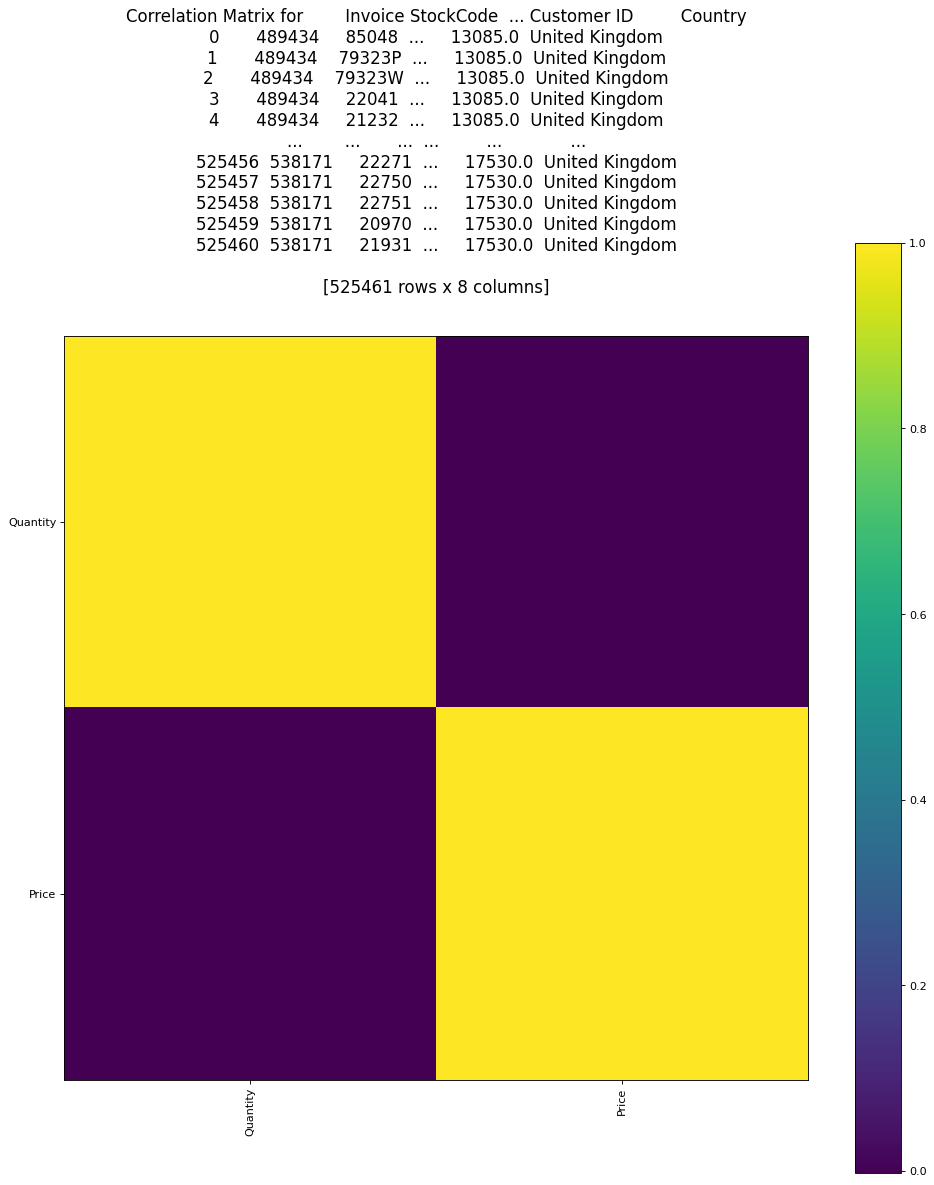

In [18]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        returncorr = retail_df.corr()
    corr = df.corr()
    plt.figure(num = None, figsize=(graphWidth,graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

plotCorrelationMatrix(retail_df, 15)


## Scatter and Density Plot

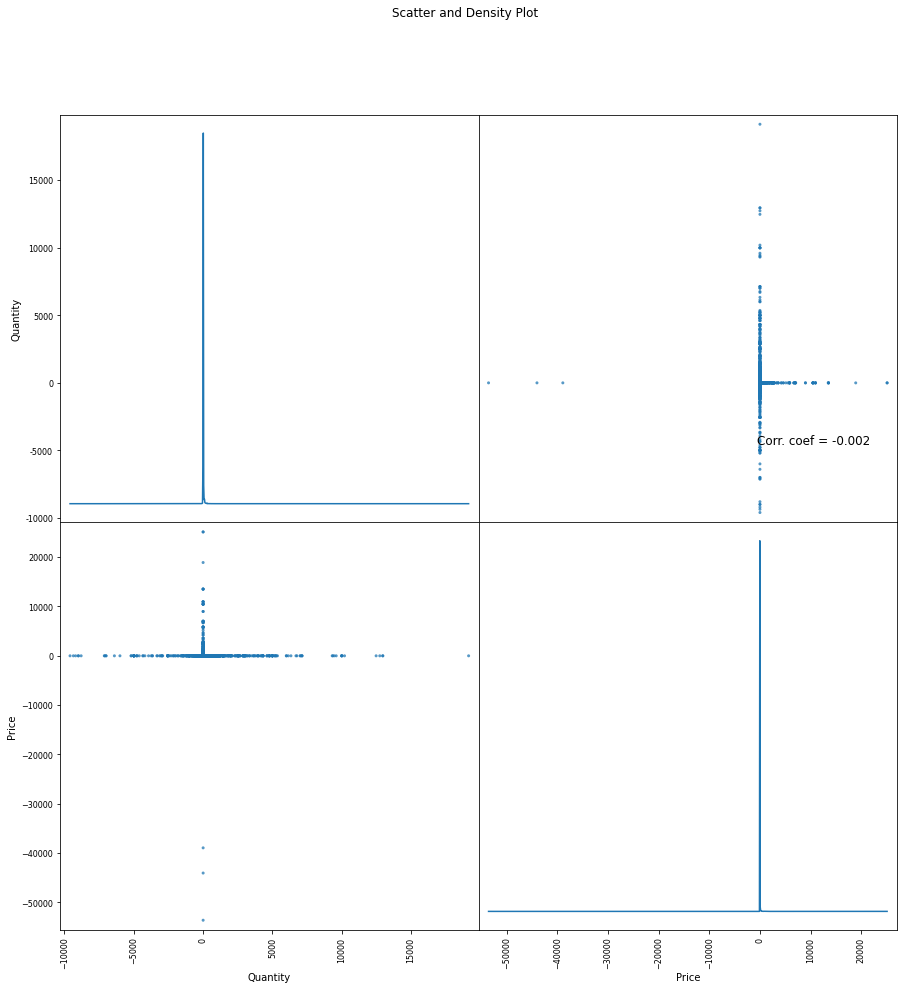

In [19]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(retail_df, 15, 12)

# Association Rules

In [20]:
#Group products by transaction
product_group = retail_df.groupby('Invoice')['Description'].apply(lambda group_series:
                                                                  group_series.tolist()).reset_index()
list_group = product_group['Description'].values.tolist()

data = list(filter(lambda x:len(x)>2, list_group))


In [21]:
from mlxtend.preprocessing import TransactionEncoder

In [22]:
tran_encoder = TransactionEncoder()
tran_encoder_arry = tran_encoder.fit(data).transform(data)
tran_encoder_df = pd.DataFrame(tran_encoder_arry, columns = tran_encoder.columns_)

tran_encoder_df

,DOORMAT UNION JACK GUNS AND ROSES,3 STRIPEY MICE FELTCRAFT,4 PURPLE FLOCK DINNER CANDLES,ANIMAL STICKERS,BLACK PIRATE TREASURE CHEST,BROWN PIRATE TREASURE CHEST,CAMPHOR WOOD PORTOBELLO MUSHROOM,CHERRY BLOSSOM DECORATIVE FLASK,FAIRY CAKE CANDLES,FLAMINGO LIGHTS,HOME SWEET HOME BLACKBOARD,IVORY PAPER CUP CAKE CASES,LARGE SKULL WINDMILL,NEW BAROQUE BLACK BOXES,OVAL WALL MIRROR DIAMANTE,PAINT YOUR OWN CANVAS SET,PEACE WOODEN BLOCK LETTERS,RED/WHITE DOT MINI CASES,RIDGED GLASS T-LIGHT HOLDER,SET 2 TEA TOWELS I LOVE LONDON,SET Of 6 SOLDIER SKITTLES,SILVER CHERRY LIGHTS,SILVER T-LIGHT SETTING,STAR T-LIGHT HOLDER,VINTAGE DESIGN GIFT TAGS,WHITE BAMBOO RIBS LAMPSHADE,WHITE CHERRY LIGHTS,*Boombox Ipod Classic,*USB Office Glitter Lamp,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 MINI TOADSTOOL PEGS,12 PENCIL SMALL TUBE WOODLAND,...,"WRAPPING PAPER, XMAS VILLAGE",YELLOW + BROWN BEAR FELT PURSE KIT,YELLOW BIRDS FELT DES FOODCOVER,YELLOW BREAKFAST CUP AND SAUCER,YELLOW BROWN BEAR FELT PURSE KIT,YELLOW COAT RACK PARIS FASHION,YELLOW DRAGONFLY HELICOPTER,YELLOW EASTER EGG HUNT START POST,YELLOW FELT HANGING HEART W FLOWER,YELLOW FLOWERS FELT HANDBAG KIT,YELLOW GIANT GARDEN THERMOMETER,YELLOW KNITTED KIDS RUCKSACK,YELLOW METAL CHICKEN HEART,YELLOW PINK FLOWER DESIGN BIG BOWL,YELLOW POT PLANT CANDLE,YELLOW PURPLE DAISY FELT PURSE KIT,YELLOW RABBIT SAT EASTER,YELLOW RED FLOWER PIGGY BANK,YELLOW SHARK HELICOPTER,YELLOW VW BEETLE CERAMIC MONEY BOX,YELLOW/BLUE RETRO RADIO,YELLOW/PINK CERAMIC CANDLE HOLDER,YELLOW/PINK FLOWER DESIGN BIG MUG,YOU'RE CONFUSING ME METAL SIGN,YULETIDE IMAGES GIFT WRAP SET,YULETIDE IMAGES S/6 PAPER BOXES,ZINC FINISH 15CM PLANTER POTS,ZINC FOLKART SLEIGH BELLS,ZINC HANGING HEART T-LITE HLDR,ZINC HEART LATTICE 2 WALL PLANTER,ZINC HEART LATTICE CHARGER LARGE,ZINC HEART LATTICE CHARGER SMALL,ZINC HEART LATTICE DOUBLE PLANTER,ZINC HEART LATTICE PLANTER BOWL,ZINC HEART LATTICE T-LIGHT HOLDER,ZINC HEART LATTICE TRAY OVAL,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,F

In [23]:
#%pip install mlxtend --upgrade
#rom mlxtend import frequent_patterns
#from mlxtend.frequent_patterns import eclat
from mlxtend.frequent_patterns import fpgrowth

In [25]:
tran_freq_patterns = fpgrowth(tran_encoder_df, min_support=0.005, use_colnames=True)
tran_freq_patterns

,support,itemsets
0,0.089646,(STRAWBERRY CERAMIC TRINKET BOX)
1,0.025372,(PINK DOUGHNUT TRINKET POT )
2,0.024004,(SAVE THE PLANET MUG)
3,0.016739,(PINK CHERRY LIGHTS)
4,0.015002,(15CM CHRISTMAS GLASS BALL 20 LIGHTS)
...,...,...
7362,0.007528,"(HAND WARMER RED RETROSPOT, HAND WARMER UNION ..."
7363,0.007685,"(HAND WARMER RED RETROSPOT, HAND WARMER OWL DE..."
7364,0.006475,"(HAND WARMER RED RETROSPOT, HAND WARMER UNION ..."
7365,0.006948,"(HAND WARMER RED RETROSPOT, HAND WARMER SCOTTY..."


In [34]:
from mlxtend.frequent_patterns import association_rules, apriori
association_rules(tran_freq_patterns, metric = "confidence", min_threshold=0.7)
tran_association_rules = association_rules(tran_freq_patterns, metric = "lift", min_threshold=1.2)
print(tran_association_rules)

                                             antecedents  ... conviction
0                       (STRAWBERRY CERAMIC TRINKET BOX)  ...   1.213041
1                   (WHITE HANGING HEART T-LIGHT HOLDER)  ...   1.089139
2                       (STRAWBERRY CERAMIC TRINKET BOX)  ...   1.095821
3                             (REGENCY CAKESTAND 3 TIER)  ...   1.078107
4      (STRAWBERRY CERAMIC TRINKET BOX, REGENCY CAKES...  ...   1.424303
...                                                  ...  ...        ...
18793  (HAND WARMER OWL DESIGN, HAND WARMER BIRD DESIGN)  ...   1.389309
18794                        (HAND WARMER RED RETROSPOT)  ...   1.301187
18795                    (HAND WARMER SCOTTY DOG DESIGN)  ...   1.193909
18796                           (HAND WARMER OWL DESIGN)  ...   1.185315
18797                          (HAND WARMER BIRD DESIGN)  ...   1.198415

[18798 rows x 9 columns]


Given that left hand side has two items, then which items is more likely to be added to the basket..

In [36]:
tran_association_rules['lhs items'] = tran_association_rules['antecedents'].apply(lambda x:len(x) )
tran_association_rules[tran_association_rules['lhs items']>1].sort_values('lift', ascending=False).head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,lhs items
16749,"(CHILDRENS GARDEN GLOVES BLUE, CHILDS GARDEN F...","(CHILDRENS GARDEN GLOVES PINK, CHILDS GARDEN F...",0.005632,0.005790,0.005106,0.906542,156.559813,0.005073,10.638043,2
16744,"(CHILDRENS GARDEN GLOVES PINK, CHILDS GARDEN F...","(CHILDRENS GARDEN GLOVES BLUE, CHILDS GARDEN F...",0.005790,0.005632,0.005106,0.881818,156.559813,0.005073,8.413879,2
16484,"(CHILDS GARDEN TROWEL BLUE , CHILDRENS GARDEN ...","(CHILDS GARDEN TROWEL PINK, CHILDRENS GARDEN G...",0.006738,0.005422,0.005106,0.757812,139.768583,0.005070,4.106645,2
16481,"(CHILDS GARDEN TROWEL PINK, CHILDRENS GARDEN G...","(CHILDS GARDEN TROWEL BLUE , CHILDRENS GARDEN ...",0.005422,0.006738,0.005106,0.941748,139.768583,0.005070,17.050999,3
16788,"(CHILDS GARDEN TROWEL BLUE , CHILDRENS GARDEN ...","(CHILDS GARDEN FORK BLUE , CHILDS GARDEN TROWE...",0.006738,0.005369,0.005001,0.742188,138.228784,0.004965,3.857962,2


# Visualize Analysis

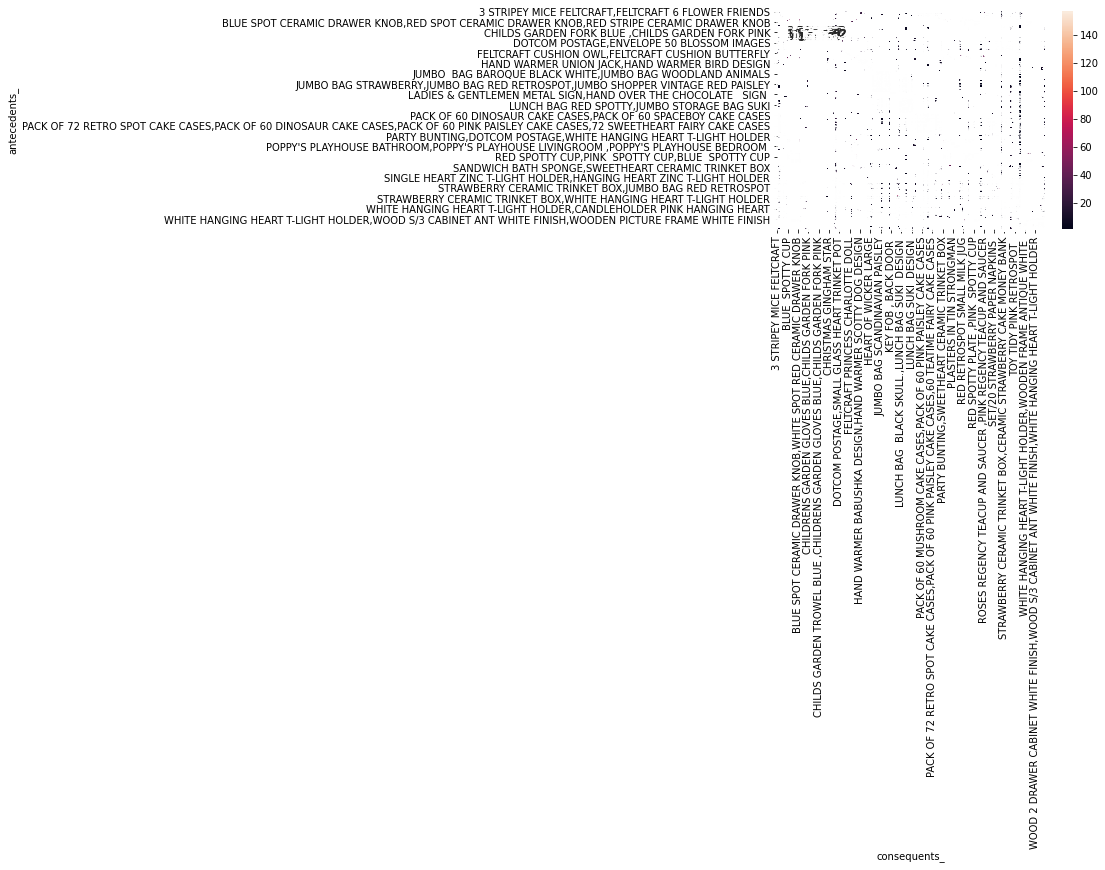

In [37]:
# Replace frozen sets with strings
tran_association_rules['antecedents_'] = tran_association_rules['antecedents'].apply(lambda a: ','.join(list(a)))
tran_association_rules['consequents_'] = tran_association_rules['consequents'].apply(lambda a: ','.join(list(a)))
# Transform the DataFrame of rules into a matrix using the lift metric
pivot = tran_association_rules[tran_association_rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [39]:
import networkx as nx

ValueError: ignored

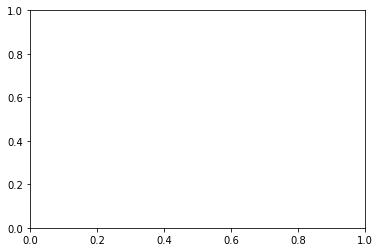

In [55]:
def draw_graph(rules, rules_to_show): 
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 5
  colors = np.random.rand(N)    
  strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']   

  strs = ['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10']

  for i in range(rules_to_show):
      G1.add_nodes_from(["R"+str(i)])
      
      for a in rules.iloc[i]['antecedents']:
          G1.add_nodes_from([a])
          G1.add_edge(a, "R"+str(i), color = colors[i], weight = 2)
          
      for c in rules.iloc[i]['consequents']:
          G1.add_nodes_from([c])
          G1.add_edge("R"+str(i), c, color = colors[i], weight = 2)
        
  for node in G1:
      found_a_string = False
      for item in strs:
          if node == item:
              found_a_string = True
          if found_a_string:
              color_map.append('yellow')
          else:
              color_map.append('green')
            
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]

  pos = nx.spring_layout(G1, k = 10, scale = 1)
  nx.draw_networkx(G1, pos, edgelist=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)

draw_graph(tran_association_rules, 1)